In [2]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
from datetime import datetime


plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [3]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

In [4]:
name_tag = '_08squdeg'
detect_limit = '_nolimit'
nz_prior = '_nz_prior'
cat_output_name = graham_output_dir+'cat_out'+name_tag+'_nonir_il'+nz_prior+detect_limit+'_formass_sfq_added.fits'
cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits'
cat_v_name = '/Volumes/LejaySSD/v11_cats/COSMOS_v11_6bands_v220127.fits'
col_list = "'RA DEC ZPHOT Z_ML'"
print(cat_output_name)

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass_sfq_added.fits


In [5]:
def gv_boundary_2(color1, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)

In [6]:
combined_cat_name = cat_output_name.replace('_sfq_added.fits','vincent_c20added.fits')

# 3-catalog match
cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
       in1='+cat_output_name+' values1="RA DEC" \
       in2='+cat_c20_name+' values2="ALPHA_J2000 DELTA_J2000" \
       in3='+cat_v_name+' values3="RA DEC" \
       out='+ combined_cat_name+' icmd3="keepcols '+col_list+'" '
os.system(cmd)
    
cat_original = Table.read(cat_output_name)
cat_matched = Table.read(combined_cat_name)

arr,ind = np.unique(cat_matched['STRING_INPUT'],return_index=True)
cat_matched = cat_matched[ind]
cat_matched = cat_matched[cat_matched['lp_zPDF']>0]
cat_matched = cat_matched[cat_matched['lp_zPDF']<7]
cat_matched = cat_matched[cat_matched['MAG_AUTO_CH1_CORR']<99]
cat_matched = cat_matched[cat_matched['MAG_AUTO_CH2_CORR']<99]
cat_matched = cat_matched[~np.isnan(cat_matched['lp_mass_med'])]

cond_ch1 = ( (cat_matched['MAG_AUTO_CH1'] > 0.) & (cat_matched['MAG_AUTO_CH1'] < 50.) & (cat_matched['MAGERR_AUTO_CH1'] > 0.) & (cat_matched['MAGERR_AUTO_CH1'] < 0.5) )
cond_ch2 = ( (cat_matched['MAG_AUTO_CH2'] > 0.) & (cat_matched['MAG_AUTO_CH2'] < 50.) & (cat_matched['MAGERR_AUTO_CH2'] > 0.) & (cat_matched['MAGERR_AUTO_CH2'] < 0.5) )
flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 

# Z_ML_1 -> Z_ML from my fitting
# Z_ML_3 -> Z_ML from Vincent
diagram_type = 'NUVrK'
phot_type=2 # 0=optical 1=w/nir 2=w/irac 3=full 
best_boxes_nuvrk = np.load('best_select_box_onemassbin_lepharecheck_'+diagram_type+'_.npy')
    
sfq_nuvrk = []
for i in tqdm(range(len(cat_matched))):
    gal = cat_matched[i]
    if abs(gal['MAG_ABS_r']) < 99. and abs(gal['MAG_ABS_Ks'])< 99. and gal['MAG_ABS_NUV']< 99. and abs(gal['MAG_ABS_r'])< 99.:
        rk = gal['MAG_ABS_r'] - gal['MAG_ABS_Ks']
        nuvr = gal['MAG_ABS_NUV'] - gal['MAG_ABS_r']
        if gal['Z_ML_1']>0 and gal['Z_ML_1']<6:
            delta_gv_nuvrk = nuvr - gv_boundary_2(rk,best_boxes_nuvrk[phot_type][0],best_boxes_nuvrk[phot_type][1],best_boxes_nuvrk[phot_type][2])
            if delta_gv_nuvrk<0:
                sfq_nuvrk.append(1.)
            else:
                sfq_nuvrk.append(0.)
        else:
            sfq_nuvrk.append(-99.)
    else:
        sfq_nuvrk.append(99.)
        
sfq_col_nuvrk = Column(name='sfq_nuvrk_myrun',data=sfq_nuvrk)  # 1=sf, 0=q
if 'sfq_nuvrk_myrun' in cat_matched.keys():
    cat_matched.remove_column('sfq_nuvrk_myrun')
cat_matched.add_column(sfq_col_nuvrk)
cat_matched.write(combined_cat_name, overwrite=True)

100%|██████████| 199841/199841 [01:57<00:00, 1706.41it/s]


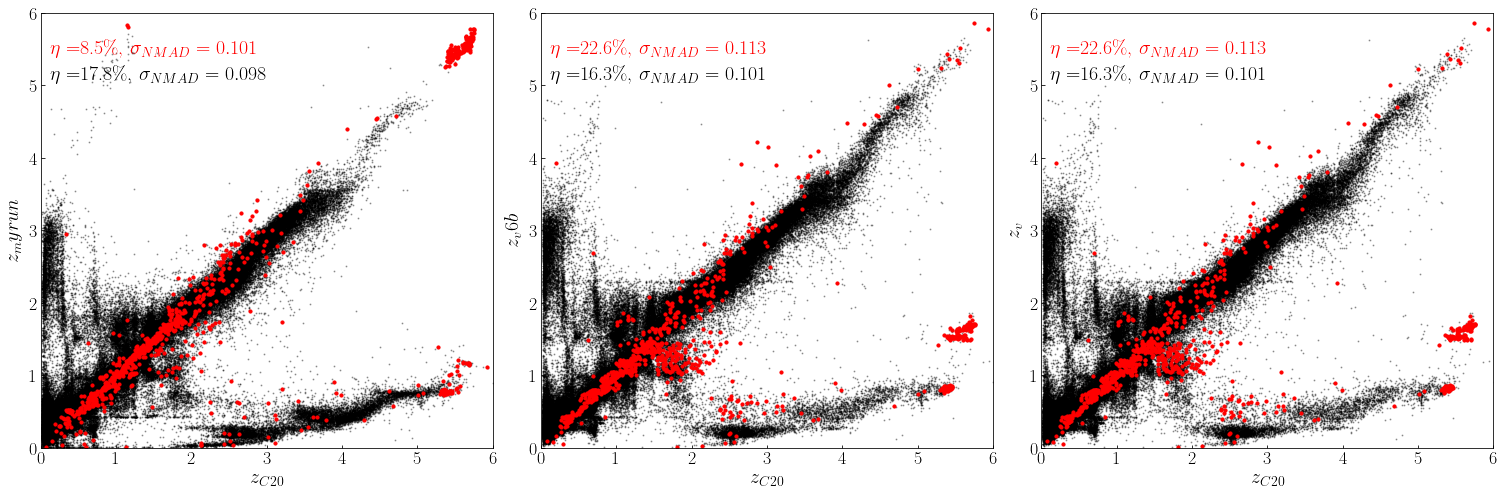

In [8]:
# redshift comparison
outlier_factor = 0.15
massive_cut = 11.2
cat = cat_matched

# Z_ML_1 -> Z_ML from my fitting
# Z_ML_3 -> Z_ML from Vincent

fig, axs = plt.subplots(1, 3, figsize = (21, 7),sharex=True)
colors= ['red','red']
z_names_toshow = ['$z_myrun$','$z_v6b$','$z_v$']
for j,z_type in enumerate(['Z_ML_1','Z_ML_3','ZPHOT_3']):
    massive_cond_myrun = cat['MASS_MED_massrun']>massive_cut
    my_massive = cat[massive_cond_myrun]
    massive_cond_v = cat['MASS_MED_old']>massive_cut # mass_med_old is mas derived from full photometry
    my_massive_v = cat[massive_cond_v]
    c20_massive = cat[cat['lp_mass_med']>massive_cut]
        
    # plot
    axs[j].scatter(cat['lp_zPDF'],cat[z_type],s=1, color='k',alpha=0.3)
    if z_type=='Z_ML':
        axs[j].scatter(cat[massive_cond_myrun]['lp_zPDF'],cat[massive_cond_myrun][z_type],s=10, color='r')
    else:
        axs[j].scatter(cat[massive_cond_v]['lp_zPDF'],cat[massive_cond_v][z_type],s=10, color='r')
            
    num_outliers = len(cat[abs(cat['lp_zPDF']-cat[z_type])>outlier_factor*(1+cat['lp_zPDF'])])
    num_outliers_massive = len(cat[massive_cond_myrun][abs(cat[massive_cond_myrun]['lp_zPDF']-cat[massive_cond_myrun][z_type])>outlier_factor*(1+cat[massive_cond_myrun]['lp_zPDF'])])
    deltaz = np.array(cat[z_type]-cat['lp_zPDF'])
    deltaz_massive = np.array(cat[massive_cond_myrun][z_type]-cat[massive_cond_myrun]['lp_zPDF'])
    sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
    sigma_massive = 1.4826*np.median(abs(deltaz_massive - np.median(deltaz_massive)))
    
    axs[j].annotate('$\eta=$'+str(round(num_outliers/len(cat)*100,1))+'\%, $\sigma_{NMAD}='+str(round(sigma,3))+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
    axs[j].annotate('$\eta=$'+str(round(num_outliers_massive/len(cat[massive_cond_myrun])*100,1))+'\%, $\sigma_{NMAD}='+str(round(sigma_massive,3))+'$',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='r')   
    axs[j].set_xlabel('$z_{C20}$',fontsize=20)
    axs[j].set_ylabel(z_names_toshow[j],fontsize=20)
    axs[j].set_xlim([0,6])
    axs[j].set_ylim([0,6])
    
plt.tight_layout()

Text(0, 0.5, 'flag IRAC')

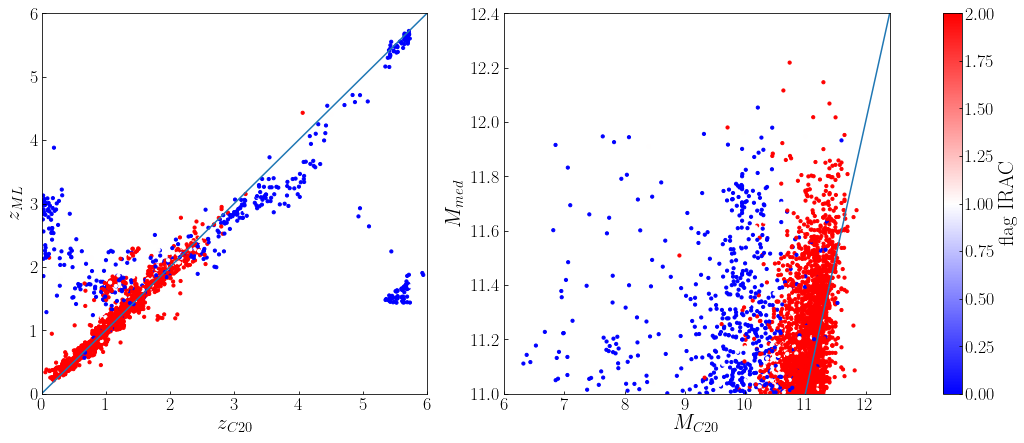

In [36]:
# massive gals
massive_cut = 11.0
cat = cat_matched
massive_cond_myrun = cat['MASS_MED_massrun']>massive_cut
cat_my_massive = cat[massive_cond_myrun]
flag_irac_massive = flag_irac[massive_cond_myrun]

peaky_check = []
for gal in cat_my_massive:
    if "N/A" in gal['pdz']:
        peaky_check.append(-1) # -1=no-pdz
    else:
        pdz = np.array(gal['pdz'].split(',')).astype(float)
        pdz_trim = pdz[np.nonzero(pdz)[0][0]:np.nonzero(pdz)[0][-1]+1]
        if len(pdz_trim[pdz_trim>0.25*np.max(pdz_trim)])<=3:
            peaky_check.append(1)  # 1=peaky
        else:
            peaky_check.append(0)  # 0=non-peaky
            
fig, axs = plt.subplots(1, 2, figsize = (19, 7))
# z-z plot
im1 = axs[0].scatter(cat_my_massive['lp_zPDF'],cat_my_massive['Z_ML_1'],s=10, c=flag_irac_massive,cmap='bwr')
axs[0].plot([0,6],[0,6])
axs[0].set_xlim([0,6])
axs[0].set_ylim([0,6])  
axs[0].set_xlabel('$z_{C20}$',fontsize=21)
axs[0].set_ylabel('$z_{ML}$',fontsize=21)

# M-M plot
im2 = axs[1].scatter(cat_my_massive['lp_mass_med'],cat_my_massive['MASS_MED_massrun'],s=10, c=flag_irac_massive,cmap='bwr')
axs[1].plot([0,13],[0,13])
axs[1].set_xlim([6,12.4])
axs[1].set_ylim([11.0,12.4])  
axs[1].set_xlabel('$M_{C20}$',fontsize=21)
axs[1].set_ylabel('$M_{med}$',fontsize=21)

cbar = fig.colorbar(im1, ax=axs)
cbar.ax.set_ylabel('flag IRAC',fontsize=21)


$9.8<M<11.0$ z_C20 in this bin 8171 z_ML in this bin 6832
399 637 0.8361


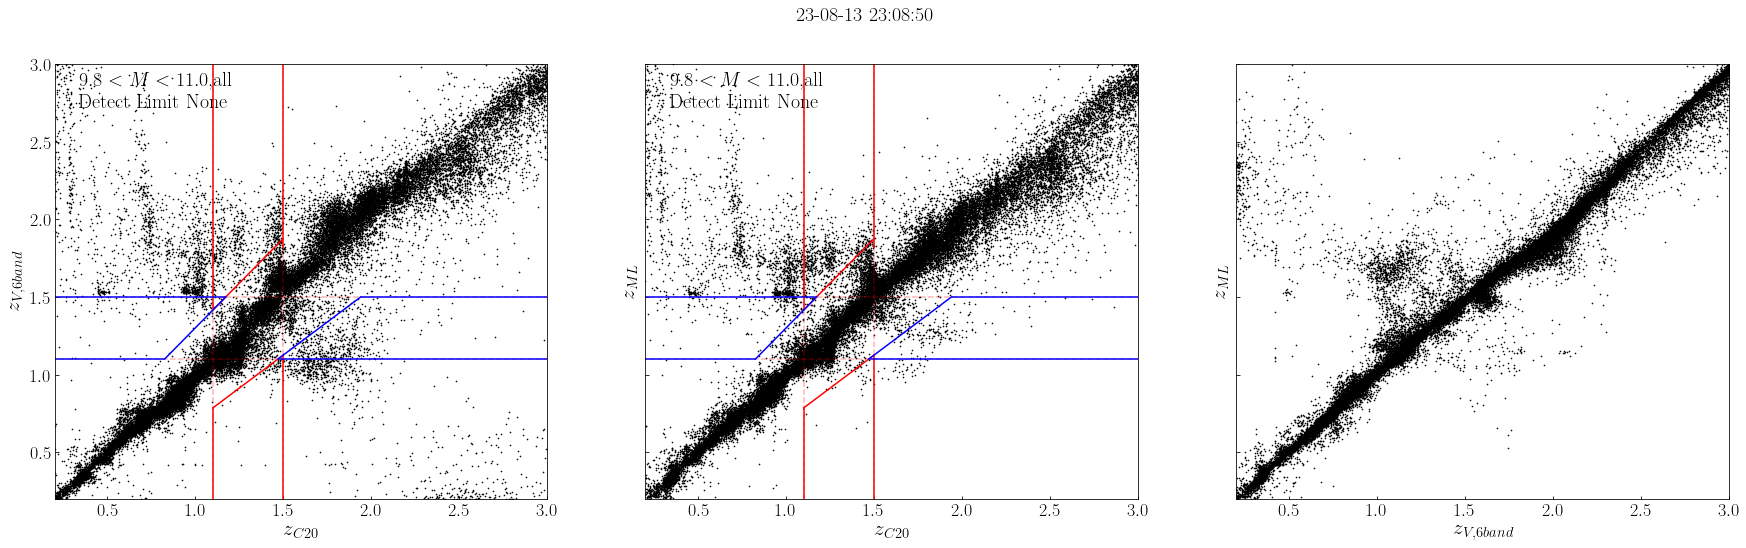

In [10]:
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
i=3

fig, axs = plt.subplots(1, 3, figsize = (30, 8), sharex=True, sharey=True)
time = datetime.now()
time = time.strftime("%y-%m-%d %H:%M:%S")
plt.suptitle(time,fontsize=20)
m_low = 9.8
m_high= 11.0
sfq = 'all'
cat_v_keyname = 'ZPHOT_3'

# sample selection/cut
z_cond = cat_matched['flag_photoz']==1
mass_cond = abs(cat_matched['MASS_MED_massrun']-(m_low+m_high)/2)<(m_high - m_low)/2
cat_select = cat_matched[mass_cond]

# sf/q
if sfq == 'q':
    cat_select = cat_select[cat_select['sfq_nuvrk_myrun']==0]
elif sfq == 'sf':
    cat_select = cat_select[cat_select['sfq_nuvrk_myrun']==1]
else:
    pass

pdz = False
if pdz:
    pdz_flags = []
    peaky_check = []
    for gal in cat_select:
        if "N/A" in gal['pdz']:
            pdz_flags.append(0)
            peaky_check.append(-1) # -1=no-pdz
        else:
            pdz = np.array(gal['pdz'].split(',')).astype(float)
            pdz_flags.append(1)
            pdz_trim = pdz[np.nonzero(pdz)[0][0]:np.nonzero(pdz)[0][-1]+1]
            if len(pdz_trim[pdz_trim>0.25*np.max(pdz_trim)])<=3:
                peaky_check.append(1)  # 1=peaky
            else:
                peaky_check.append(0)  # 0=non-peaky

    pdz_flags = np.array(pdz_flags)
    peaky_check = np.array(peaky_check)
    print('peaky:',len(peaky_check[peaky_check==1]),'non-peaky:',len(peaky_check[peaky_check==0]))
    # cat_select = cat_select[pdz_flags==1]
else:
    pdz_flags = np.ones(len(cat_select))
    peaky_check = np.ones(len(cat_select))

im1 = axs[0].scatter(cat_select['lp_zPDF'],cat_select[cat_v_keyname],s=0.4,c='k',cmap='bwr')
im2 = axs[1].scatter(cat_select['lp_zPDF'],cat_select['Z_ML_1'],s=0.4,c='k',cmap='bwr')
im3 = axs[2].scatter(cat_select[cat_v_keyname],cat_select['Z_ML_1'],s=0.4,c='k',cmap='bwr')

axs[0].set_xlim([0.2,3])
axs[0].set_ylim([0.2,3])
axs[0].set_ylabel(r'$z_{V,6band}$',fontsize=21)
axs[1].set_ylabel(r'$z_{ML}$',fontsize=21)
axs[2].set_xlabel(r'$z_{V,6band}$',fontsize=21)
axs[2].set_ylabel(r'$z_{ML}$',fontsize=21)
# cbar = fig.colorbar(im1, ax=axs)
# cbar.ax.set_ylabel('PDZ peaky flag',fontsize=21)

for axs_idx in range(2):
    axs[axs_idx].annotate('Detect Limit None',xy=([0.05,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[axs_idx].annotate('$'+str(m_low)+'<M<'+str(m_high)+'$,'+sfq,xy=([0.05,0.95]),xycoords='axes fraction',fontsize=20,color='k')
    
    axs[axs_idx].vlines(x=z_mins[i],ymin=0,ymax=8,color='r',ls='--',alpha=0.3)
    axs[axs_idx].vlines(x=z_maxs[i],ymin=0,ymax=8,color='r',ls='--',alpha=0.3)
    axs[axs_idx].hlines(y=z_mins[i],xmin=0,xmax=8,color='r',ls='--',alpha=0.3)
    axs[axs_idx].hlines(y=z_maxs[i],xmin=0,xmax=8,color='r',ls='--',alpha=0.3)
    
    # vertical box
    axs[axs_idx].plot([z_mins[i],z_maxs[i]],[z_mins[i]+0.15*(1+z_mins[i]),z_maxs[i]+0.15*(1+z_maxs[i])],color='r')
    axs[axs_idx].vlines(x=z_mins[i],ymin=z_mins[i]+0.15*(1+z_mins[i]),ymax=8,color='r')
    axs[axs_idx].vlines(x=z_maxs[i],ymin=z_maxs[i]+0.15*(1+z_mins[i]),ymax=8,color='r')
    axs[axs_idx].plot([z_mins[i],z_maxs[i]],[z_mins[i]-0.15*(1+z_mins[i]),z_maxs[i]-0.15*(1+z_maxs[i])],color='r')
    axs[axs_idx].vlines(x=z_mins[i],ymin=0,ymax=z_mins[i]-0.15*(1+z_mins[i]),color='r')
    axs[axs_idx].vlines(x=z_maxs[i],ymin=0,ymax=z_maxs[i]-0.15*(1+z_maxs[i]),color='r')
    
    # horizontal box
    axs[axs_idx].plot([(z_mins[i]+0.15)/(1-0.15),(z_maxs[i]+0.15)/(1-0.15)],[z_mins[i],z_maxs[i]],color='b')
    axs[axs_idx].hlines(y=z_mins[i],xmin=(z_mins[i]+0.15)/(1-0.15),xmax=8,color='b')
    axs[axs_idx].hlines(y=z_maxs[i],xmin=(z_maxs[i]+0.15)/(1-0.15),xmax=8,color='b')
    axs[axs_idx].plot([(z_mins[i]-0.15)/(1+0.15),(z_maxs[i]-0.15)/(1+0.15)],[z_mins[i],z_maxs[i]],color='b')
    axs[axs_idx].hlines(y=z_mins[i],xmin=0,xmax=(z_mins[i]-0.15)/(1+0.15),color='b')
    axs[axs_idx].hlines(y=z_maxs[i],xmin=0,xmax=(z_maxs[i]-0.15)/(1+0.15),color='b')
    axs[axs_idx].set_xlabel(r'$z_{C20}$',fontsize=21)
    
cat_true = cat_select[np.logical_and(cat_select['lp_zPDF']>z_mins[i],cat_select['lp_zPDF']<z_maxs[i])]
cat_my_z =cat_select[np.logical_and(cat_select['Z_ML_1']>z_mins[i],cat_select['Z_ML_1']<z_maxs[i])]
cat_outliers1 = cat_my_z[abs(cat_my_z['Z_ML_1']-cat_my_z['lp_zPDF'])>0.15*(1+cat_my_z['lp_zPDF'])]
cat_outliers2 = cat_true[abs(cat_true['Z_ML_1']-cat_true['lp_zPDF'])>0.15*(1+cat_true['lp_zPDF'])]

print('$'+str(m_low)+'<M<'+str(m_high)+'$','z_C20 in this bin',len(cat_true),'z_ML in this bin',len(cat_my_z))
print(len(cat_outliers1),len(cat_outliers2),round(len(cat_my_z)/len(cat_true),4))


#### Check on 50k sample

In [12]:
# make input catalog for 50k sample
# from central cosmos region

cat_ccosmos = Table.read('/Users/lejay/research/lephare_dev/my_code/input_cats/COSMOS_deep_base_08squdeg.fits')
select_ids = np.random.choice(np.arange(len(cat_ccosmos)), size=50000, replace=False)
cat_select_ccosmos = cat_ccosmos[select_ids]
cat_select_ccosmos.write('/Users/lejay/research/lephare_dev/my_code/input_cats/COSMOS_deep_base_08squdeg_50k.fits', overwrite=True)

In [21]:
# re-fitted massive gals
fiftyk_output_dir = dev_path+'50k_output_cats/'

cat_50k_612 = Table.read(fiftyk_output_dir+'cat_out_50k_nonir_nolimit_mrange_6_12.fits')
cat_50k_6125 = Table.read(fiftyk_output_dir+'cat_out_50k_nonir_nolimit_mrange_6_125.fits')
cat_50k_616 = Table.read(fiftyk_output_dir+'cat_out_50k_nonir_nolimit_mrange_6_16.fits')
cat_50k_910 = Table.read(fiftyk_output_dir+'cat_out_50k_nonir_nolimit_mrange_9_10.fits')

cat_50k_612 = cat_50k_612['RA','DEC','Z_ML','MASS_MED_massrun']
cat_50k_6125 = cat_50k_6125['Z_ML','MASS_MED_massrun']
cat_50k_616 = cat_50k_616['Z_ML','MASS_MED_massrun']
cat_50k_910 = cat_50k_910['Z_ML','MASS_MED_massrun','MASS_BEST']

cat_50k = hstack([cat_50k_612,cat_50k_6125,cat_50k_616,cat_50k_910],table_names=['612','6125','616','910'])
cat_50k.write(fiftyk_output_dir+'/cat_out_50k_zmass_check.fits',overwrite=True)

In [26]:
cat_50k_name = fiftyk_output_dir+'/cat_out_50k_zmass_check.fits'
cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits'
combined_cat_name = cat_50k_name.replace('.fits','c20added.fits')
    
col_list = "'RA DEC MASS_MED ZPHOT sfq_nuvrk'"
cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
    in1='+cat_50k_name+' values1="RA DEC" \
    in2='+cat_c20_name+' values2="ALPHA_J2000 DELTA_J2000" \
    in3=/Users/lejay/research/massive_gals/clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params_sfq_added.fits values3="RA DEC" \
    out='+ combined_cat_name+' icmd3="keepcols '+col_list+'" '
# print(cmd)       
os.system(cmd)

0

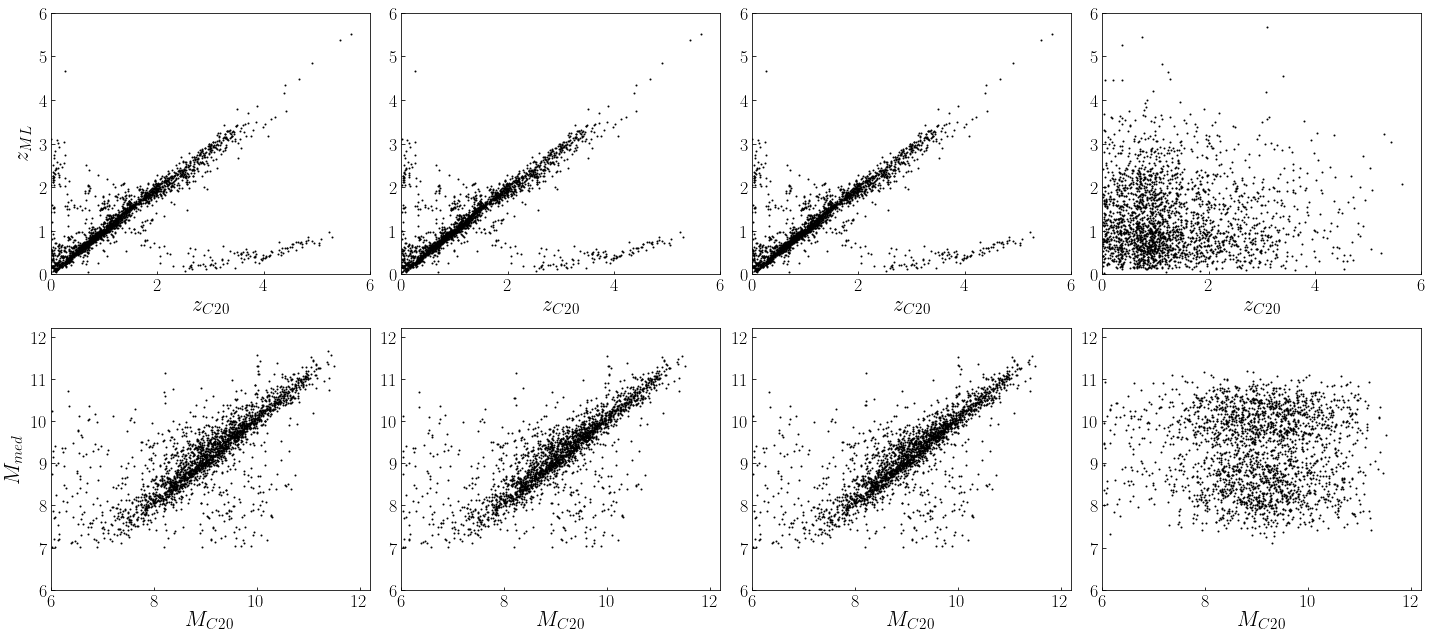

In [35]:
# something
cat_50k_combined = Table.read(cat_50k_name.replace('.fits','c20added.fits'))
# flags
# flag_photoz = cat_50k_combined['flag_photoz']==1  # consistent photoz within C20 catalog
# flag_optical = cat_50k_combined['flag_optical'] 
# flag_irac = cat_50k_combined['flag_irac'] 
# flag_nir = cat_50k_combined['flag_nir'] 

# selection condition
# cond_filters = (flag_optical>=4) & (flag_irac>=1) & flag_photoz
# cat_massive_combined = cat_massive_combined[cond_filters]

fig, axs = plt.subplots(2,4, figsize = (20, 9))

# z-z plot
axs[0][0].scatter(cat_50k_combined['lp_zPDF'],cat_50k_combined['Z_ML_612'],s=1,color='k')
axs[0][1].scatter(cat_50k_combined['lp_zPDF'],cat_50k_combined['Z_ML_6125'],s=1,color='k')
axs[0][2].scatter(cat_50k_combined['lp_zPDF'],cat_50k_combined['Z_ML_616'],s=1,color='k')
axs[0][3].scatter(cat_50k_combined['lp_zPDF'],cat_50k_combined['Z_ML_910'],s=1,color='k')
axs[0][0].set_xlim([0,6])
axs[0][0].set_ylim([0,6])
axs[0][1].set_xlim([0,6])
axs[0][1].set_ylim([0,6])
axs[0][2].set_xlim([0,6])
axs[0][2].set_ylim([0,6])
axs[0][3].set_xlim([0,6])
axs[0][3].set_ylim([0,6])
axs[0][0].set_xlabel('$z_{C20}$',fontsize=22)
axs[0][1].set_xlabel('$z_{C20}$',fontsize=22)
axs[0][2].set_xlabel('$z_{C20}$',fontsize=22)
axs[0][3].set_xlabel('$z_{C20}$',fontsize=22)
axs[0][0].set_ylabel('$z_{ML}$',fontsize=22)

# M-M plot
axs[1][0].scatter(cat_50k_combined['lp_mass_med'],cat_50k_combined['MASS_MED_massrun_612'],s=1,color='k')
axs[1][1].scatter(cat_50k_combined['lp_mass_med'],cat_50k_combined['MASS_MED_massrun_6125'],s=1,color='k')
axs[1][2].scatter(cat_50k_combined['lp_mass_med'],cat_50k_combined['MASS_MED_massrun_616'],s=1,color='k')
axs[1][3].scatter(cat_50k_combined['lp_mass_med'],cat_50k_combined['MASS_MED_massrun_910'],s=1,color='k')
axs[1][0].set_xlim([6,12.2])
axs[1][0].set_ylim([6,12.2])
axs[1][1].set_xlim([6,12.2])
axs[1][1].set_ylim([6,12.2])
axs[1][2].set_xlim([6,12.2])
axs[1][2].set_ylim([6,12.2])
axs[1][3].set_xlim([6,12.2])
axs[1][3].set_ylim([6,12.2])
axs[1][0].set_xlabel('$M_{C20}$',fontsize=22)
axs[1][1].set_xlabel('$M_{C20}$',fontsize=22)
axs[1][2].set_xlabel('$M_{C20}$',fontsize=22)
axs[1][3].set_xlabel('$M_{C20}$',fontsize=22)
axs[1][0].set_ylabel('$M_{med}$',fontsize=22)

plt.tight_layout()

(6, 13)

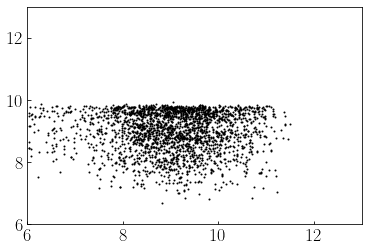

In [34]:
plt.scatter(cat_50k_combined['lp_mass_med'],cat_50k_combined['MASS_BEST'],s=1,color='k')
plt.xlim([6,13])
plt.ylim([6,13])

####  PDZ check

In [67]:
cat = cat_matched
cond = abs(cat['MASS_MED_massrun']-(m_low+m_high)/2)<(m_high - m_low)/2
cat_select = cat[cond]

# redshift cuts
cat_z_select = cat_select[cat_select['Z_ML_1']>0.5]
cat_z_select = cat_z_select[cat_z_select['Z_ML_1']<0.8]
cat_z_select = cat_z_select[cat_z_select['lp_zPDF']>0.9]
cat_z_select = cat_z_select[cat_z_select['lp_zPDF']<2.0]
print('length of catalog:',len(cat_z_select))

# remove N/A's from PDZ list
pdz_list = []
pdz_flag = []
for gal in cat_z_select:
    if "N/A" not in gal['pdz']:
        pdz = np.array(gal['pdz'].split(',')).astype(float)
        pdz_list.append(pdz)
        pdz_flag.append(True)
    else:
        pdz_flag.append(False) 
        
cat_z_select = cat_z_select[np.array(pdz_flag)]

peaky_check = []
for i,gal in enumerate(cat_z_select):
    pdz = pdz_list[i]
    pdz_zbins = np.linspace(0,6,len(pdz))
    
    #trim the non zeros in pdz
    pdz_zbins_trim = pdz_zbins[np.nonzero(pdz)[0][0]:np.nonzero(pdz)[0][-1]+1]
    pdz_trim = pdz[np.nonzero(pdz)[0][0]:np.nonzero(pdz)[0][-1]+1]
    if len(pdz_trim[pdz_trim>0.25*np.max(pdz_trim)])<=2:
        peaky_check.append(1) # peaky
    else:
        peaky_check.append(0) # non-peaky

peaky_check = np.array(peaky_check)
pdz_col = Column(name='pdz_check', data=peaky_check)
cat_z_select.add_column(pdz_col)

length of catalog: 198


In [4]:
# check ch1/ch2 mag

cond1 = cat_z_select['pdz_check']==1
cat_z_peaky = cat_z_select[cond1]
print(len(cat_z_peaky),len(cat_z_peaky[cat_z_peaky['MAG_AUTO_CH1_CORR']>0]),len(cat_z_peaky[cat_z_peaky['MAG_AUTO_CH1_CORR']<0]))
plt.hist(cat_z_peaky['MAG_AUTO_CH1_CORR'],bins=15,histtype='step')

cond2 = cat_z_select['pdz_check']==0
cat_z_nonpeaky = cat_z_select[cond2]
print(len(cat_z_nonpeaky),len(cat_z_nonpeaky[cat_z_nonpeaky['MAG_AUTO_CH1_CORR']>0]),len(cat_z_nonpeaky[cat_z_nonpeaky['MAG_AUTO_CH1_CORR']<0]))
plt.hist(cat_z_nonpeaky['MAG_AUTO_CH1_CORR'],bins=15,histtype='step')

plt.show()

NameError: name 'cat_z_select' is not defined

total: 8 peaky: 4 non-peaky: 4


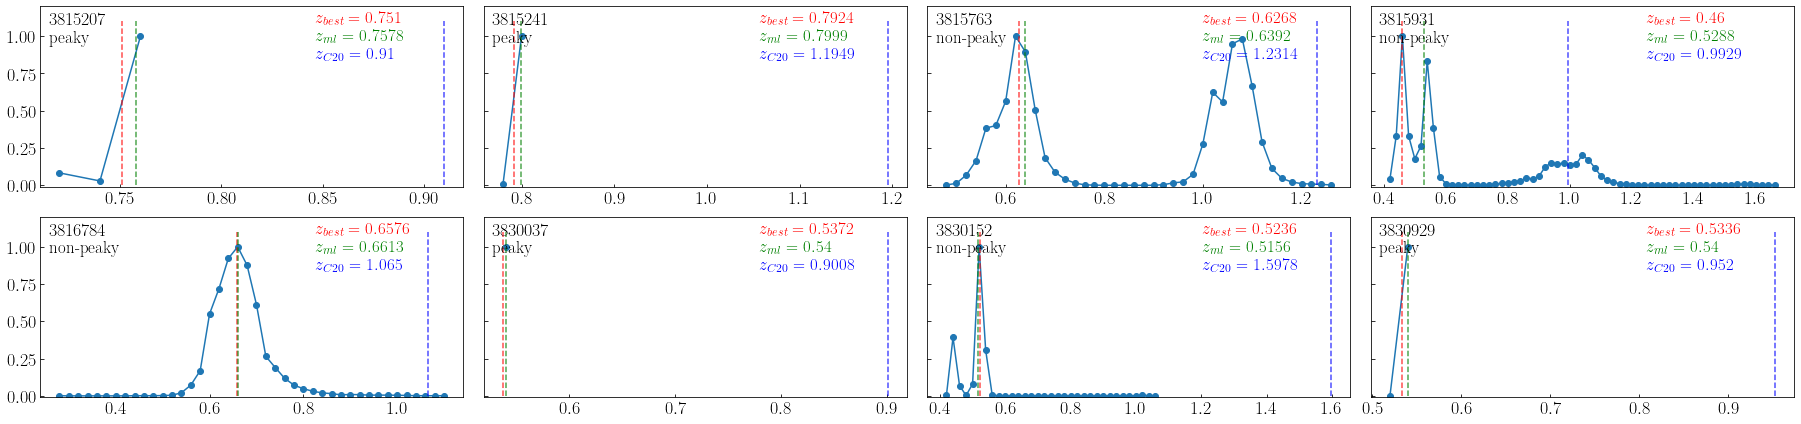

In [65]:
indices = np.arange(8)
cat_z_select = cat_z_select[indices]
pdz_list = np.array(pdz_list)
pdz_list = pdz_list[indices]

# plot
col_count = 4
row_count = len(cat_z_select)//col_count+int(len(cat_z_select)%col_count!=0)
fig, axs = plt.subplots(row_count, col_count, figsize = (25, (len(cat_z_select)//4)*3+int(len(cat_z_select)%col_count!=0)), sharey=True)
peaky_count = 0
nonpeaky_count = 0
for i,gal in enumerate(cat_z_select):
    pdz = pdz_list[i]
    pdz_zbins = np.linspace(0,6,len(pdz))
    ID = gal['STRING_INPUT']
    z_best = gal['Z_BEST']
    z_ml = gal['Z_ML_1']
    z_c20 = gal['lp_zPDF']
    # print(pdz)
    
    #trim the non zeros in pdz
    pdz_zbins_trim = pdz_zbins[np.nonzero(pdz)[0][0]:np.nonzero(pdz)[0][-1]+1]
    pdz_trim = pdz[np.nonzero(pdz)[0][0]:np.nonzero(pdz)[0][-1]+1]
    if len(pdz_trim[pdz_trim>0.25*np.max(pdz_trim)])<=2:
        peaky_count += 1
        peaky_check = 'peaky'
    else:
        nonpeaky_count += 1
        peaky_check = 'non-peaky'
        
    row = i//4
    col = i%4
    axs[row][col].plot(pdz_zbins_trim,pdz_trim,'o-')
    axs[row][col].annotate(ID,xy=([0.02,0.9]),xycoords='axes fraction',fontsize=18,color='k')
    axs[row][col].plot([z_best,z_best],[0,1.1],'--r',alpha=0.7)
    axs[row][col].plot([z_ml,z_ml],[0,1.1],'--g',alpha=0.7)
    axs[row][col].plot([z_c20,z_c20],[0,1.1],'--b',alpha=0.7)
    
    axs[row][col].annotate(peaky_check,xy=([0.02,0.8]),xycoords='axes fraction',fontsize=17,color='k')
    axs[row][col].annotate('$z_{best}='+str(z_best)+'$',xy=([0.65,0.9]),xycoords='axes fraction',fontsize=17,color='r')
    axs[row][col].annotate('$z_{ml}='+str(z_ml)+'$',xy=([0.65,0.8]),xycoords='axes fraction',fontsize=17,color='g')
    axs[row][col].annotate('$z_{C20}='+str(z_c20)+'$',xy=([0.65,0.7]),xycoords='axes fraction',fontsize=17,color='b')
    
# axs[0][0].set_xlim([0,6])
print('total:',peaky_count+nonpeaky_count, 'peaky:',peaky_count,'non-peaky:',nonpeaky_count)
axs[0][0].set_ylim([-0.01,1.2])
plt.tight_layout()

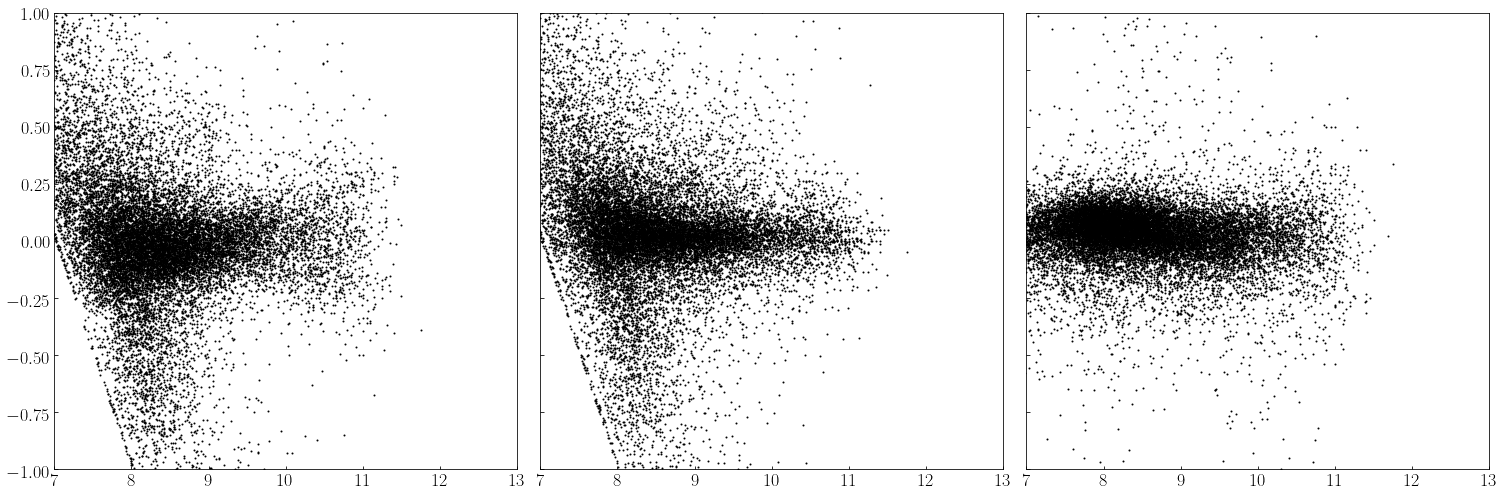

In [11]:
# mass comparison

fig, axs = plt.subplots(1, 3, figsize = (21, 7), sharey=True)
cat_name = graham_output_dir+'cat_out_300k_allphot_il_formass.fits'
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added_sfq_added.fits'))

cat_z = cat_output_c20added[cat_output_c20added['Z_ML']>0.2]
cat_z = cat_z[cat_z['Z_ML']<0.5]
cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
flag_photoz = cat_z['flag_photoz']==1  
# cond_photoz_match = abs(cat_z['Z_BEST'] - cat_z['lp_zPDF'])<0.15*(1+cat_z['lp_zPDF'])
# cond = flag_photoz & cond_photoz_match 
# cat_z = cat_z[cond]

axs[0].scatter(cat_z['lp_mass_med'],cat_z['MASS_MED_massrun'] - cat_z['lp_mass_med'],s=1,color='k')
axs[0].set_xlim(7,13)
axs[0].set_ylim(-1,1)

axs[1].scatter(cat_z['lp_mass_med'],cat_z['MASS_MED'] - cat_z['lp_mass_med'],s=1,color='k')
axs[1].set_xlim(7,13)
axs[1].set_ylim(-1,1)

axs[2].scatter(cat_z['lp_mass_med'],cat_z['MASS_MED'] - cat_z['MASS_MED_massrun'],s=1,color='k')
axs[2].set_xlim(7,13)
axs[2].set_ylim(-1,1)

plt.tight_layout()

In [ ]:
# internal mass comparison

